## Import libraries

In [133]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.eval_measures import aic
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

pd.set_option("display.precision", 2)

## Import the file, create data frames, and create the necessary variables

In [14]:
xls = pd.ExcelFile('Data.xlsx')
df = xls.parse(0)
factors_df = xls.parse(1)

In [15]:
df['Time'] = pd.to_datetime(df['Time'])
factors_df['Time'] = pd.to_datetime(factors_df['Time'])

Limit the observations until 2018:Q3

In [16]:
df = df.iloc[0:234]
df.tail()

,Time,GDPC1,PCECTPI,TB3MS,GS10
229,2017-09-30,19304.35,98.95,0.43,2.13
230,2017-12-30,19398.34,99.52,0.59,2.44
231,2018-03-30,19506.95,99.72,0.89,2.26
232,2018-06-30,19660.77,100.08,1.04,2.24
233,2018-09-30,19882.35,100.68,1.21,2.37


Create $\log(GDPC1)$ and $\Delta \log(GDPC1)$

In [17]:
df['log_GDP'] = np.log(df['GDPC1'])

df['delta_log_GDP'] = (df['log_GDP'] - df['log_GDP'].shift(1))
df['delta_log_GDP'].fillna(0, inplace=True)

Create $\pi$ and $\log(PCECTPI)$

In [18]:
df['infl'] = (np.log(df['PCECTPI']) - (np.log(df['PCECTPI'])).shift(1))
df['infl'].fillna(0, inplace=True)

df['log_PCECTPI'] = np.log(df['PCECTPI'])

Create $TSpread$

In [19]:
df['tspread'] = df['GS10'] - df['TB3MS']

In [20]:
df.head()

,Time,GDPC1,PCECTPI,TB3MS,GS10,log_GDP,delta_log_GDP,infl,log_PCECTPI,tspread
0,1960-06-30,3430.06,15.33,3.54,4.50,8.14,0.00e+00,0.00e+00,2.73,0.96
1,1960-09-30,3439.83,15.41,4.23,4.58,8.14,2.85e-03,5.46e-03,2.74,0.35
2,1960-12-30,3517.18,15.44,3.87,4.49,8.17,2.22e-02,1.30e-03,2.74,0.61
3,1961-03-30,3498.25,15.52,2.99,4.26,8.16,-5.40e-03,5.17e-03,2.74,1.27
4,1961-06-30,3515.39,15.57,2.36,3.83,8.16,4.89e-03,3.80e-03,2.75,1.47


## **Model 1: Random Walk**

Since the prediction for the next period is the last observed value, all we have to do is to shift(1) the series, and then consider only the prediction starting from 1985:Q2.

In [21]:
rw_predictions = df['log_GDP'].shift(1)

# bring it into real terms
exp_rw_predictions = np.exp(rw_predictions)

# consider only from 1985:Q3
exp_rw_predictions = exp_rw_predictions[100:]

# compute RMSE for RW
rmse_rw = mean_squared_error(df['GDPC1'].iloc[100:], exp_rw_predictions, squared=False).round(2)
print(rmse_rw)

119.44


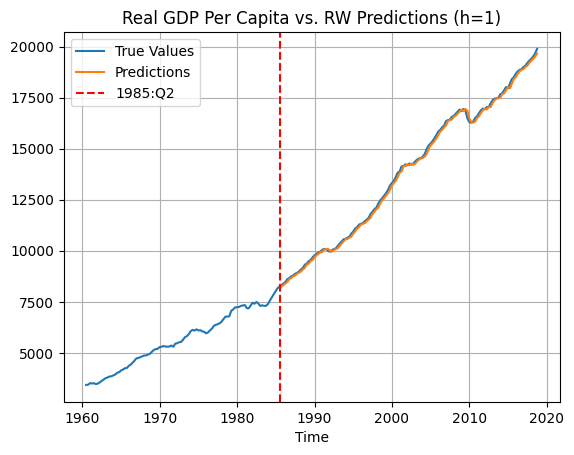

In [27]:
plt.plot(df['Time'], df['GDPC1'], label='True Values')
plt.plot(df['Time'].iloc[100:], exp_rw_predictions, label='Predictions')
plt.grid()
plt.xlabel('Time')
plt.title('Real GDP Per Capita vs. RW Predictions (h=1)')
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()
plt.show()

## **Model 2: AR(4)**

In [23]:
ar_4_forecasts = []

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    ar_4_model = ARIMA(current_window['delta_log_GDP'], order=(4,0,0)) 
    ar_4_results = ar_4_model.fit()

    # forecast the next observation
    ar_4_forecast = ar_4_results.forecast(steps=1)

    # append the forecasted value to the list
    ar_4_forecasts.append(ar_4_forecast.iloc[0])

    # roll the window
    t += 1

Now that we modelled $\Delta \hat{y_{t}}$ with an `AR(4)` model, we have to obtain the values for $\hat{y_{t}}$ coming from the `AR(4)` model.
For this reason, we need to exploit:

$\Delta \hat{y_{h}} = \hat{y}_{t+h} - \hat{y}_{t+h-1}$

$\hat{y}_{t+h} = \Delta \hat{y}_{h} + \hat{y}_{t+h-1}$

Where $\Delta \hat{y}_{h}$ is estimated thanks to the model, and the same for $\hat{y}_{t+h-1}$ which is the previous period, both included into `ar_4_forecasts`.

For loop to derive estimate of GDP from delta GDP: 

In [61]:
ar_4_GDP_estimates = np.zeros(134)
window_size = 100

for i in range(0,len(ar_4_GDP_estimates)):
    ar_4_GDP_estimates[i] = ar_4_forecasts[i] + df['log_GDP'].iloc[i+window_size-1]

ar_4_GDP_estimates = np.exp(ar_4_GDP_estimates)

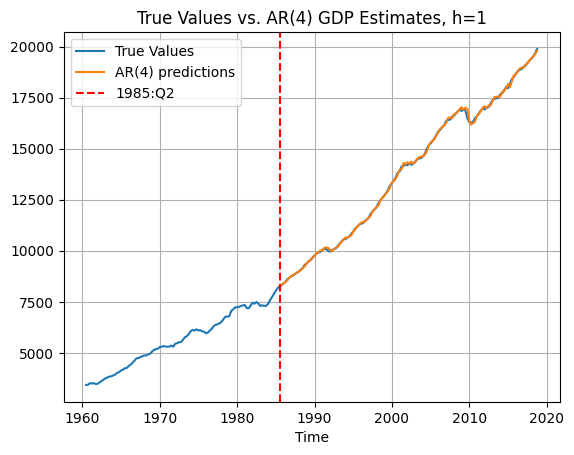

In [64]:
plt.plot(df['Time'], df['GDPC1'], label='True Values')
plt.plot(df['Time'].iloc[100:], ar_4_GDP_estimates, label='AR(4) predictions')
plt.title('True Values vs. AR(4) GDP Estimates, h=1')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

In [65]:
# compute RMSE for AR(4)
rmse_ar4 = mean_squared_error(df['GDPC1'].iloc[100:], ar_4_GDP_estimates, squared=False).round(2)
print(rmse_ar4)

79.97


## **Model: VAR(4)**
For the model VAR(4) we have to forecast $\Delta y_t$, $\pi_t$ and $Tspread_t$. In order to do I will create a new df containing only these 3 series, making it easier to pass them as an argument to the function. 

In [66]:
df_var = df[['Time', 'delta_log_GDP', 'infl', 'tspread']]
df_var = df_var.set_index('Time')
df_var.index = pd.DatetimeIndex(df_var.index).to_period('Q')

In [67]:
var_4_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_4_model = VAR(current_window) 
    var_4_results = var_4_model.fit(4)

    # forecast the next observation
    var_4_forecast = var_4_results.forecast(y = current_window.values[-4:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_4_forecast[0]], 
                            'infl': [var_4_forecast[1]], 
                            'tspread': [var_4_forecast[2]]})

    # append the forecasted value to the list
    var_4_forecasts = pd.concat([var_4_forecasts, temp_df])

    # roll the window
    t += 1

In [68]:
var_4_GDP_estimates = np.zeros(134)

for i in range(0,len(var_4_GDP_estimates)):
    var_4_GDP_estimates[i] = var_4_forecasts['delta_log_GDP'].iloc[i] + df['log_GDP'].iloc[i+window_size-1]

var_4_GDP_estimates = np.exp(var_4_GDP_estimates)

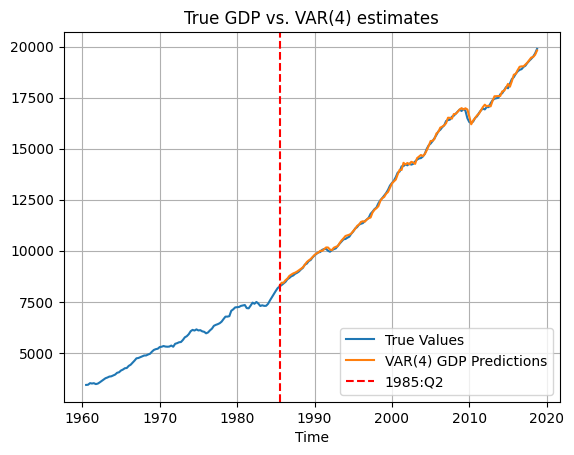

In [70]:
plt.plot(df['Time'], df['GDPC1'], label='True Values')
plt.plot(df['Time'].iloc[100:], var_4_GDP_estimates, label='VAR(4) GDP Predictions')
plt.title('True GDP vs. VAR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

In [49]:
# compute RMSE for VAR(4)
rmse_var4 = mean_squared_error(df['GDPC1'].iloc[100:], var_4_GDP_estimates, squared=False).round(2)
print(rmse_var4)

93.38


## **Model: VAR(p)**

In [51]:
var_p_forecasts = pd.DataFrame(columns=['delta_log_GDP', 'infl', 'tspread'])

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df_var.iloc[t:t+window_size]

    # create the model and fit it
    var_p_model = VAR(current_window) 
    x = var_p_model.select_order(maxlags=8)
    p = x.selected_orders['aic']

    var_p_results = var_p_model.fit(p)

    # forecast the next observation
    var_p_forecast = var_p_results.forecast(y = current_window.values[-p:], steps = 1)[0]
    temp_df = pd.DataFrame({'delta_log_GDP' : [var_p_forecast[0]], 
                            'infl': [var_p_forecast[1]], 
                            'tspread': [var_p_forecast[2]]})

    # append the forecasted value to the list
    var_p_forecasts = pd.concat([var_p_forecasts, temp_df])

    # roll the window
    t += 1


c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been pro

In [52]:
var_p_GDP_estimates = np.zeros(134)

for i in range(0,len(var_p_GDP_estimates)):
    var_p_GDP_estimates[i] = var_p_forecasts['delta_log_GDP'].iloc[i] + df['log_GDP'].iloc[i+window_size-1]

var_p_GDP_estimates = np.exp(var_p_GDP_estimates)

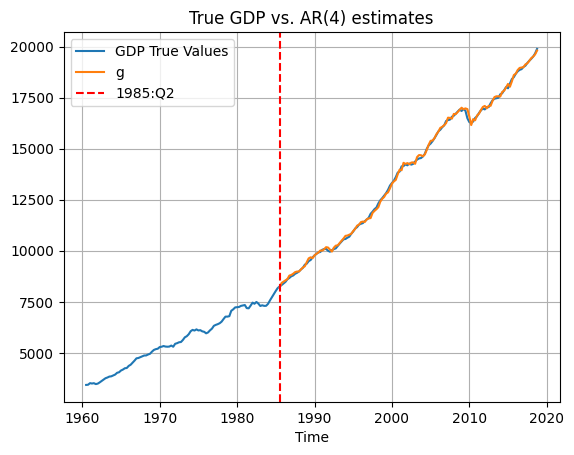

In [53]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], var_p_GDP_estimates, label='g')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

In [54]:
# compute RMSE for VAR(p)
rmse_var_p = mean_squared_error(df['GDPC1'].iloc[100:], var_p_GDP_estimates, squared=False).round(2)
print(rmse_var_p)

97.83


## **Model: AR(4)-X**

### Calculate Principal Component

Create `stand_factors` as a data frame containing 245 columns, namely all the columns of factors_df except the _Time_, but standardized ($\mu =0$, $\sigma=1$).

`factors_df` doesn't change.

In [55]:
stand_factors = factors_df.iloc[:, 1:].apply(stats.zscore, axis=0)

In [56]:
stand_factors.head()

,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,A014RE1Q156NBEA,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
0,0.35,0.20,1.00,-2.75e-01,-1.83,0.06,0.64,0.73,-0.50,-0.64,...,0.98,-0.51,-0.83,-0.77,-0.75,0.17,0.07,0.10,-0.12,-0.17
1,-0.95,-2.02,0.74,-3.28e-03,0.55,-0.97,-0.49,-0.68,-0.72,0.54,...,-2.14,-0.85,-1.02,-0.49,-1.93,0.88,-0.55,-0.56,0.44,-0.61
2,0.22,0.61,0.19,-4.25e-01,2.08,1.09,0.71,1.10,0.59,2.72,...,1.90,-0.45,0.03,-0.21,1.85,-1.01,-0.71,-0.78,1.13,-0.57
3,0.65,0.31,0.56,5.51e-01,-2.57,-1.27,0.13,0.15,-1.97,0.20,...,0.43,-0.43,-0.53,-0.46,-0.43,0.10,-0.34,-0.40,0.45,-0.24
4,-1.67,-0.69,-1.63,-1.40e+00,-0.28,-1.43,-1.88,-1.40,-0.75,0.54,...,0.46,-0.51,-0.08,-0.10,-0.95,0.47,-0.38,-0.49,0.16,0.01


In [57]:
ar_x_forecasts = []
pca = PCA(n_components=1)

window_size = 100

t = 0

for i in range(1, 135):

    # determine the training data at each step
    current_window = df.iloc[t:t+window_size]

    # create the model and fit it
    curr_stand_factors = stand_factors[t:t+window_size]

    Pcs = pca.fit_transform(curr_stand_factors)
    Pcs = np.roll(Pcs, 1)
    Pcs[0] = 0
    first_PC = Pcs[-1]

    ar_x_model = SARIMAX(current_window['delta_log_GDP'], exog = Pcs,  order = (4,0,0)) 
        
    ar_x_results = ar_x_model.fit()

    # forecast the next observation
    ar_x_forecast = ar_x_results.forecast(steps=1, exog = first_PC)

    # append the forecasted value to the list
    ar_x_forecasts.append(ar_x_forecast.iloc[0])

    # roll the window
    t += 1


In [58]:
ar_x_GDP_estimates = np.zeros(134)

for i in range(0,len(ar_x_GDP_estimates)):
    ar_x_GDP_estimates[i] = ar_x_forecasts[i] + df['log_GDP'].iloc[i+window_size-1]

ar_x_GDP_estimates = np.exp(ar_x_GDP_estimates)

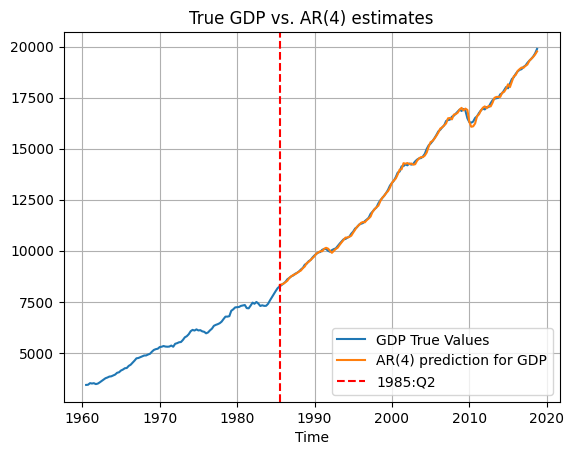

In [59]:
plt.plot(df['Time'], df['GDPC1'], label='GDP True Values')
plt.plot(df['Time'].iloc[100:], ar_x_GDP_estimates, label='AR(4) prediction for GDP')
plt.title('True GDP vs. AR(4) estimates')
plt.xlabel('Time')
plt.grid()
plt.xlim()
plt.axvline(x=pd.to_datetime('1985-06-30'), color='red', linestyle='--', label='1985:Q2')
plt.legend()

## **Section 1**

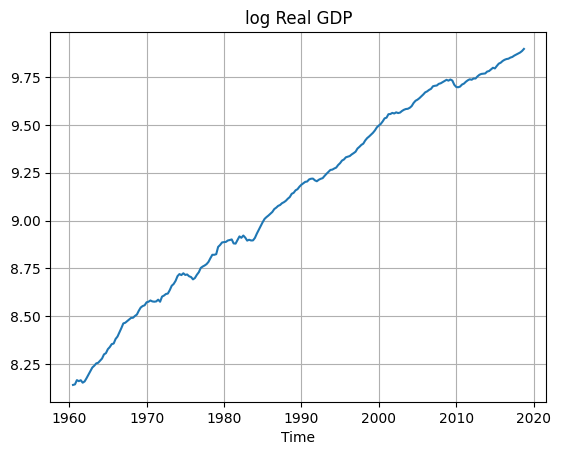

In [148]:
plt.plot(df['Time'], df['log_GDP'])
plt.title('log Real GDP')
plt.xlabel('Time')
plt.grid()

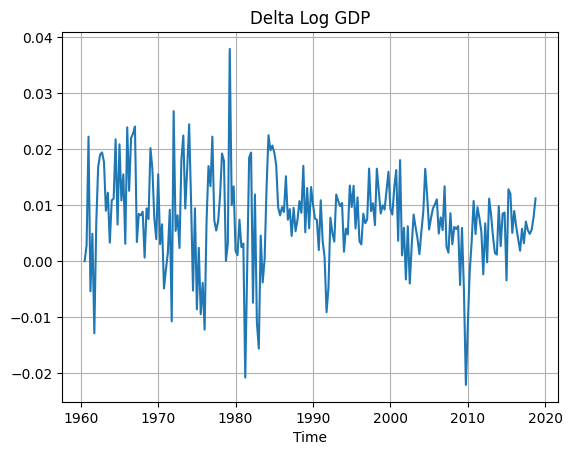

In [147]:
plt.plot(df['Time'], df['delta_log_GDP'])
plt.title('Delta Log GDP')
plt.xlabel('Time')
plt.grid()

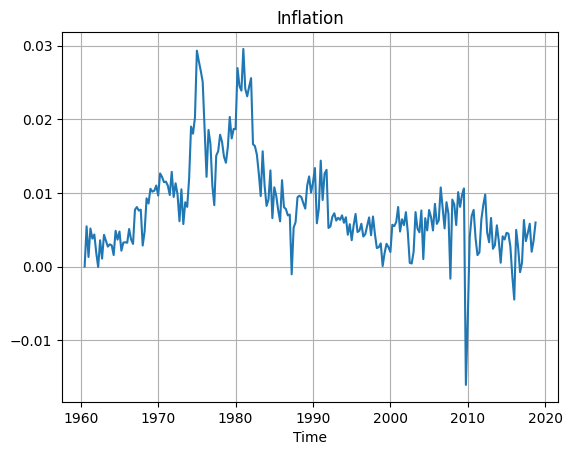

In [149]:
plt.plot(df['Time'], df['infl'], label='Inflation')
plt.title('Inflation')
plt.xlabel('Time')
plt.grid()

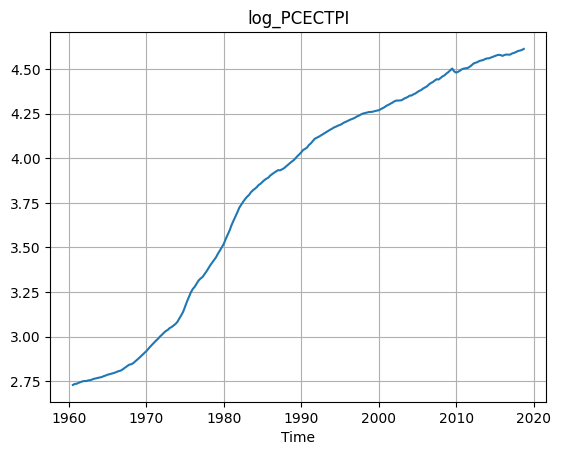

In [150]:
plt.plot(df['Time'], df['log_PCECTPI'])
plt.title('log_PCECTPI')
plt.xlabel('Time')
plt.grid()

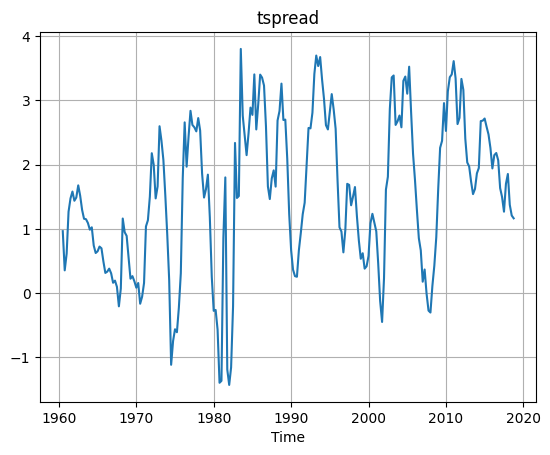

In [152]:
plt.plot(df['Time'], df['tspread'])
plt.title('tspread')
plt.xlabel('Time')
plt.grid()

## **Section 2**

Compute ACF for the three series.

([<matplotlib.axis.XTick at 0x22c196aa090>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

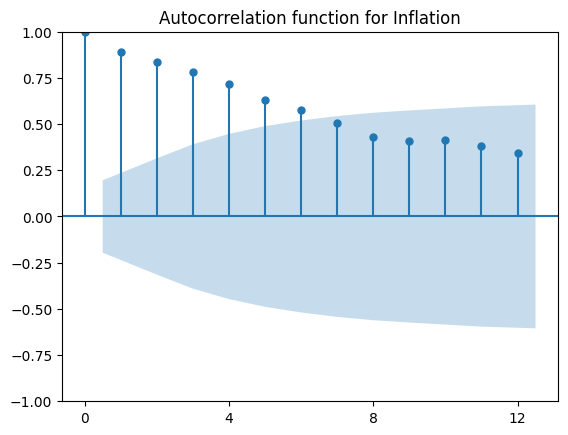

In [118]:
plot_acf(df_var['infl'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for Inflation");
plt.xticks([0,4,8,12])

([<matplotlib.axis.XTick at 0x22c197a2d90>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

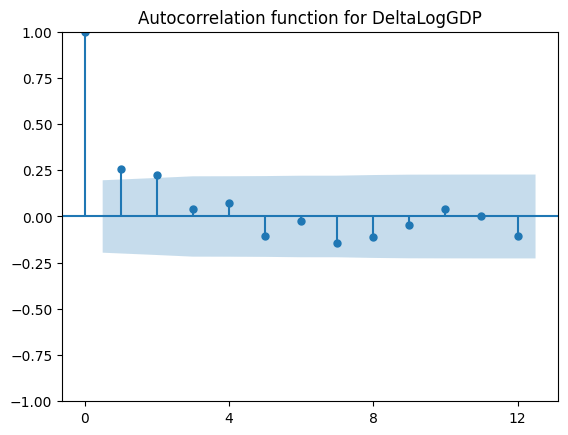

In [119]:
plot_acf(df_var['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for DeltaLogGDP");
plt.xticks([0,4,8,12])

([<matplotlib.axis.XTick at 0x22c1982d050>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

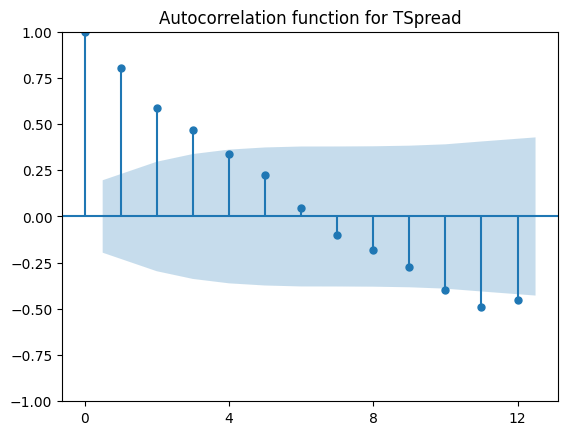

In [120]:
plot_acf(df_var['tspread'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for TSpread");
plt.xticks([0,4,8,12])

Use AIC to select the lag order.

In [121]:
sec2_model = VAR(df_var.iloc[:100])
x = sec2_model.select_order()
p = x.selected_orders['aic']

x.summary()

,AIC,BIC,FPE,HQIC
0,-18.75,-18.67,7.165e-09,-18.72
1,-21.42,-21.08*,4.999e-10,-21.28*
2,-21.42,-20.83,4.995e-10,-21.18
3,-21.43,-20.58,4.952e-10,-21.09
4,-21.70,-20.60,3.787e-10,-21.26
5,-21.70,-20.35,3.817e-10,-21.15
6,-21.63,-20.03,4.116e-10,-20.99
7,-21.76,-19.91,3.652e-10,-21.01
8,-21.86,-19.75,3.372e-10,-21.01
9,-21.80,-19.44,3.648e-10,-20.85


Estimate the model.

In [122]:
sec2_results = sec2_model.fit(p)
sec2_results.resid

,delta_log_GDP,infl,tspread
Time,,,
1963Q2,-2.44e-03,6.82e-04,0.08
1963Q3,-1.35e-03,-4.51e-04,-0.03
1963Q4,2.53e-04,-2.78e-03,0.08
1964Q1,-1.88e-04,-1.10e-03,-0.48
1964Q2,3.43e-03,4.47e-04,-0.10
...,...,...,...
1984Q1,9.67e-04,-3.99e-04,-0.29
1984Q2,-1.26e-03,-9.95e-04,0.17
1984Q3,6.43e-04,-2.12e-04,-0.83


Plot the residuals of the three series.

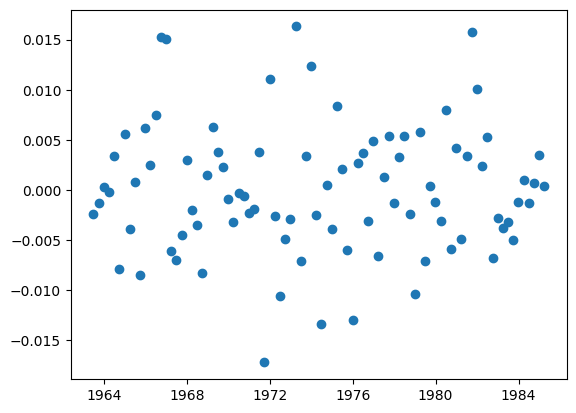

In [127]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['delta_log_GDP'])

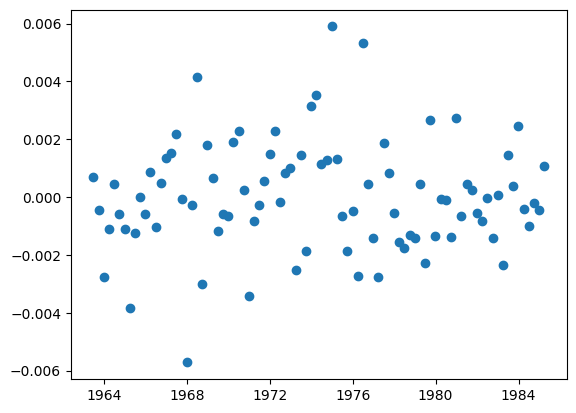

In [128]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['infl'])

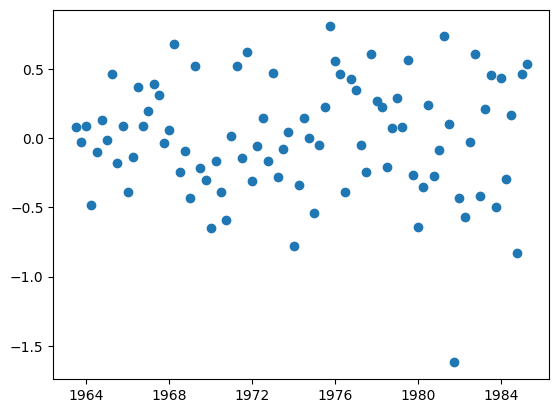

In [129]:
plt.scatter(df['Time'].iloc[12:100], sec2_results.resid['tspread'])

Plot ACF of the residuals.

([<matplotlib.axis.XTick at 0x22c1b007490>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

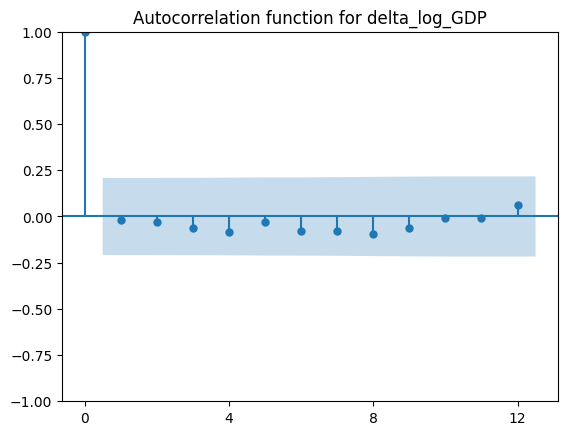

In [130]:
plot_acf(sec2_results.resid['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for delta_log_GDP");
plt.xticks([0,4,8,12])

([<matplotlib.axis.XTick at 0x22c1b03cd50>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

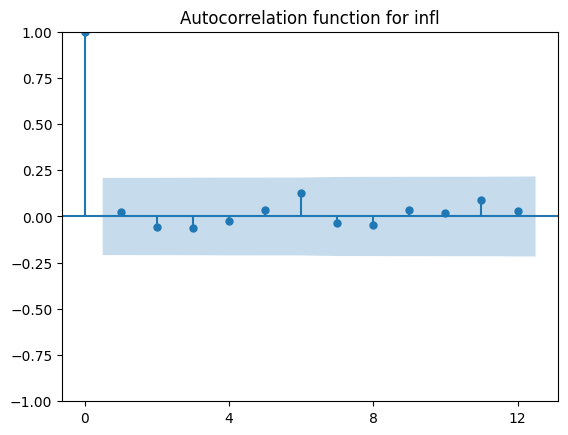

In [131]:
plot_acf(sec2_results.resid['infl'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for infl");
plt.xticks([0,4,8,12])

([<matplotlib.axis.XTick at 0x22c1b267950>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

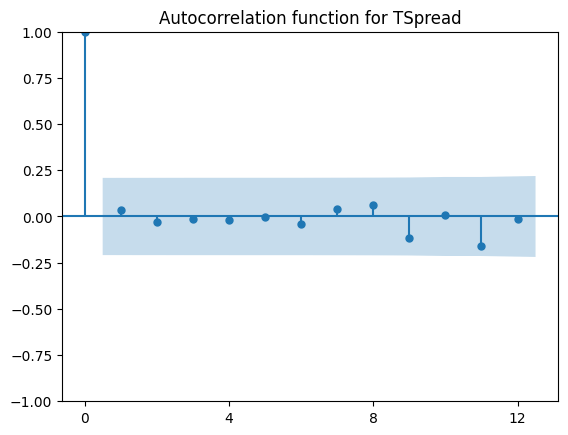

In [132]:
plot_acf(sec2_results.resid['tspread'].iloc[:100], 
         lags=12, 
         title="Autocorrelation function for TSpread");
plt.xticks([0,4,8,12])

Plot PACFs for the residuals.

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


([<matplotlib.axis.XTick at 0x22c1b348dd0>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

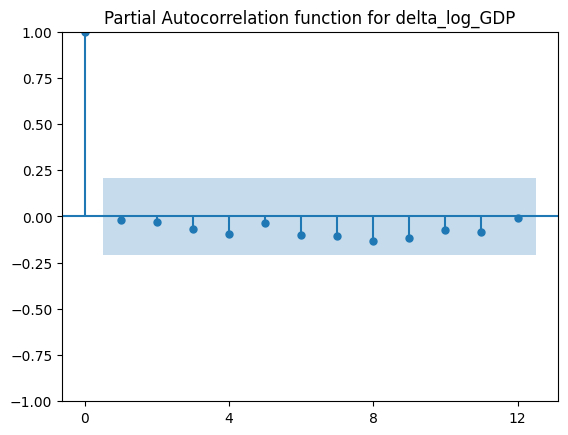

In [137]:
plot_pacf(sec2_results.resid['delta_log_GDP'].iloc[:100], 
         lags=12, 
         title="Partial Autocorrelation function for delta_log_GDP");
plt.xticks([0,4,8,12])

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


([<matplotlib.axis.XTick at 0x22c1b1931d0>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

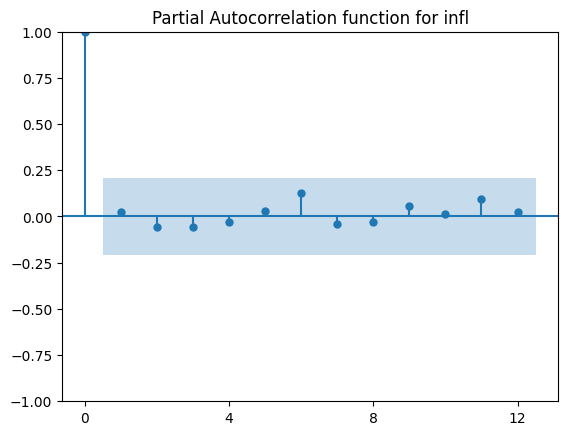

In [138]:
plot_pacf(sec2_results.resid['infl'].iloc[:100], 
         lags=12, 
         title="Partial Autocorrelation function for infl");
plt.xticks([0,4,8,12])

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


([<matplotlib.axis.XTick at 0x22c1c417f50>,
 [Text(0, 0, '0'), Text(4, 0, '4'), Text(8, 0, '8'), Text(12, 0, '12')])

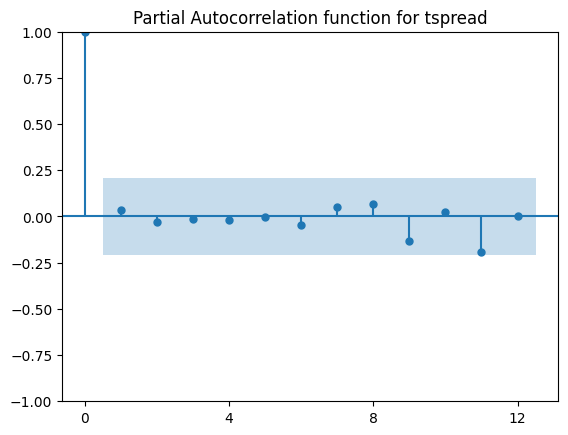

In [139]:
plot_pacf(sec2_results.resid['tspread'].iloc[:100], 
         lags=12, 
         title="Partial Autocorrelation function for tspread");
plt.xticks([0,4,8,12])

## **Section 3**

In [128]:
sec3_pc = pca.fit_transform(stand_factors[:100])


array([[ 3.6825339 ],
       [ 3.02906689],
       [-9.67634122],
       [ 5.97342069],
       [ 7.84937401],
       [10.4671106 ],
       [ 6.62284055],
       [-3.87248935],
       [-5.67072105],
       [-8.02963382]])

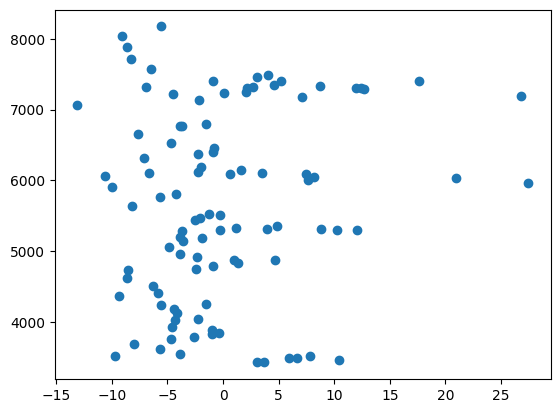

In [131]:
plt.scatter(sec3_pc, df['GDPC1'].iloc[:100])


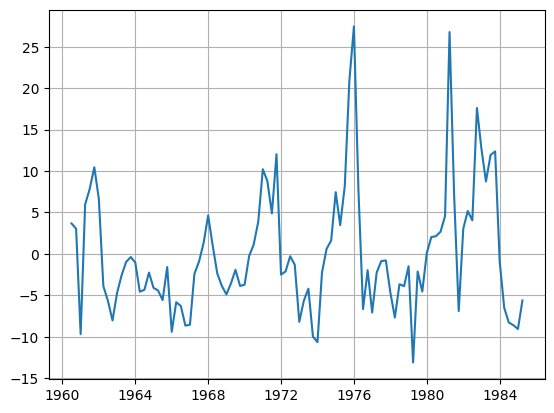

In [134]:
plt.plot(df['Time'].iloc[:100], sec3_pc)
#plt.plot(df['Time'].iloc[:100], df['GDPC1'].iloc[:100])
plt.grid()

In [150]:
np.corrcoef(sec3_pc.flatten(), df['GDPC1'].iloc[:100])

array([[1.        , 0.13241645],
       [0.13241645, 1.        ]])